# Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sys.path.append("/Users/paolo/Documents/methods/CMI_FS")
from feature_selection import forwardFeatureSelection

sys.path.append("/Users/paolo/Documents/methods/GenLinCFA")
from GenLinCFA import GenLinCFA

sys.path.append("/Users/paolo/Documents/Droughts/Paolo/regression_NonLinCFA")
from aux import standardize,unfold_dataset,compute_r2,prepare_target,prepare_target_binary,prepare_features,aggregate_unfolded_data,aggregate_unfolded_data_onlyTrain,FS_with_linearWrapper,compare_methods, compute_r2


In [2]:
def plot_cells(output,selected_colnames, xmin=9, xmax=11, ymin=44, ymax=45.5):
    x = []
    y = []
    colors = cm.rainbow(np.linspace(0,1,len(output)))
    np.random.shuffle(colors)
    fig, ax = plt.subplots(2)
    ax[0].set_xlim(xmin,xmax)
    ax[1].set_xlim(xmin,xmax)
    ax[0].set_ylim(ymin,ymax)
    ax[1].set_ylim(ymin,ymax)
    for i in range(len(output)): 
        #print(len(output[i]))
        x = []
        y = []
        
        for datum in output[i]:
            x.append(float(datum.split('_')[1]))
            y.append(float(datum.split('_')[2]))
        ax[0].scatter(x,y,color=colors[i])
    
    x = []
    y = []
    col = cm.rainbow(np.linspace(0,1,len(selected_colnames)))
    for i in range(len(selected_colnames)): 
        idx = int(selected_colnames[i].split('_')[-1])
        for datum in output[idx]:
            x.append(float(datum.split('_')[1]))
            y.append(float(datum.split('_')[2]))
        ax[1].scatter(x,y,color=col[i])
    

In [3]:
import tensorflow as tf

print(f'tensorflow version {tf.__version__}')

from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import * 

import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

tensorflow version 2.10.0


In [14]:
def MTL_scores(clust_basins, df_train, df_val, df_test, targets_df_train, targets_df_val, targets_df_test):
    
    colnames = [x for x in df_train.columns if x.startswith(tuple(clust_basins))]

    clusterdf_train_withClass = pd.DataFrame()
    clusterdf_val_withClass = pd.DataFrame()
    clusterdf_test_withClass = pd.DataFrame()

    for i in range(len(clust_basins)):
        clusterdf_train_withClass = pd.concat((clusterdf_train_withClass,pd.concat((df_train[colnames],pd.DataFrame(1+i*np.ones(len(df_train)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_val_withClass = pd.concat((clusterdf_val_withClass,pd.concat((df_val[colnames],pd.DataFrame(1+i*np.ones(len(df_val)),columns=['basin'])),axis=1)),axis=0)
        clusterdf_test_withClass = pd.concat((clusterdf_test_withClass,pd.concat((df_test[colnames],pd.DataFrame(1+i*np.ones(len(df_test)),columns=['basin'])),axis=1)),axis=0)
    
    for i in range(len(clust_basins)):
        clusterdf_train_withClass[clust_basins[i]] = clusterdf_train_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_val_withClass[clust_basins[i]] = clusterdf_val_withClass.apply(lambda x: int(x.basin==i+1),axis=1)
        clusterdf_test_withClass[clust_basins[i]] = clusterdf_test_withClass.apply(lambda x: int(x.basin==i+1),axis=1)

    clusterdf_train_withClass = clusterdf_train_withClass.loc[:,clusterdf_train_withClass.columns != 'basin']
    clusterdf_val_withClass = clusterdf_val_withClass.loc[:,clusterdf_val_withClass.columns != 'basin']
    clusterdf_test_withClass = clusterdf_test_withClass.loc[:,clusterdf_test_withClass.columns != 'basin']

    targets_df_train_unfolded = pd.DataFrame()
    targets_df_val_unfolded = pd.DataFrame()
    targets_df_test_unfolded = pd.DataFrame()
    
    for basin in clust_basins:
        targets_df_train_unfolded =  pd.concat((targets_df_train_unfolded,targets_df_train[basin]),axis=0)
        targets_df_val_unfolded =  pd.concat((targets_df_val_unfolded,targets_df_val[basin]),axis=0)
        targets_df_test_unfolded =  pd.concat((targets_df_test_unfolded,targets_df_test[basin]),axis=0)
    targets_df_train_unfolded = targets_df_train_unfolded.reset_index(drop=True)
    targets_df_val_unfolded = targets_df_val_unfolded.reset_index(drop=True)
    targets_df_test_unfolded = targets_df_test_unfolded.reset_index(drop=True)

    model_ohe = LogisticRegression()
    model_ohe.fit(pd.concat((clusterdf_train_withClass,clusterdf_val_withClass)),pd.concat((targets_df_train_unfolded,targets_df_val_unfolded)))
    
    for basin in clust_basins:
        print(basin)
        res = model_ohe.predict(clusterdf_test_withClass.loc[clusterdf_test_withClass[basin]==1].values)
        print(accuracy_score(targets_df_test[basin].values, res))
        
    #plt.plot(res[0:50])
    #plt.plot(targets_df_test[basin].values[0:50])



# Target

In [5]:
### targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/'
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_targets+basin+'.csv')
    targets_df_train[basin] = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
    targets_df_val[basin] = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
    targets_df_test[basin] = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
    targets_df_trainVal[basin] = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)
    

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.010645    0.00  2001     1 -2.129508
1    2001-01-13  0.206769    0.00  2001     2 -0.927136
2    2001-01-21  0.267313    0.00  2001     3 -

# Features

In [6]:
### wrapper best 5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in basins:
    best5_wrapper_train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_train.csv')
    best5_wrapper_val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_val.csv')
    best5_wrapper_test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_test.csv')
    best5_wrapper_fulldf_train[basin+'_'+best5_wrapper_train_temp.columns.values] = best5_wrapper_train_temp
    best5_wrapper_fulldf_val[basin+'_'+best5_wrapper_val_temp.columns.values] = best5_wrapper_val_temp
    best5_wrapper_fulldf_test[basin+'_'+best5_wrapper_test_temp.columns.values] = best5_wrapper_test_temp


In [7]:
### CMI features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_test.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp
    

In [8]:
### CMI best5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_test.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp
    

# Linear regression

### Emiliani1 - Emiliani2 - Garda_Mincio: wrapper best 5

In [9]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Emiliani1
0.7017543859649122
Emiliani2
0.7807017543859649
Garda_Mincio
0.7807017543859649


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Emiliani1 - Emiliani2 - Garda_Mincio: CMI

In [10]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Emiliani1
0.6754385964912281
Emiliani2
0.6885964912280702
Garda_Mincio
0.7412280701754386


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Emiliani1 - Emiliani2 - Garda_Mincio: CMI best 5

In [11]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Emiliani1
0.6754385964912281
Emiliani2
0.706140350877193
Garda_Mincio
0.7236842105263158


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Adda - Lambro_Olona - Oglio_Iseo - Ticino: wrapper best 5

In [60]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.5921052631578947
Lambro_Olona
0.6140350877192983
Oglio_Iseo
0.6096491228070176
Ticino
0.6271929824561403


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

### Adda - Lambro_Olona - Oglio_Iseo - Ticino: CMI

In [12]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.618421052631579
Lambro_Olona
0.5964912280701754
Oglio_Iseo
0.6008771929824561
Ticino
0.6096491228070176


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegress

### Adda - Lambro_Olona - Oglio_Iseo - Ticino: CMI best 5

Adda
0.6842105263157895
Lambro_Olona
0.6885964912280702
Oglio_Iseo
0.6666666666666666
Ticino
0.7105263157894737


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

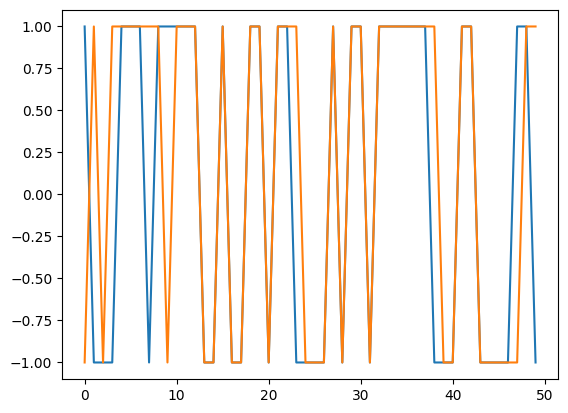

In [15]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


### Dora - Piemonte Sud - Piemonte Nord: wrapper best 5

In [10]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.5614035087719298
Piemonte_Nord
0.6447368421052632
Piemonte_Sud
0.6798245614035088


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [12]:
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Piemonte_Nord
0.6578947368421053
Piemonte_Sud
0.6885964912280702


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Dora - Piemonte Sud - Piemonte Nord: CMI

In [13]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.5263157894736842
Piemonte_Nord
0.6008771929824561
Piemonte_Sud
0.6008771929824561


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegress

In [14]:
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Piemonte_Nord
0.5789473684210527
Piemonte_Sud
0.5833333333333334


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### Dora - Piemonte Sud - Piemonte Nord: CMI best 5

In [15]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.5789473684210527
Piemonte_Nord
0.6403508771929824
Piemonte_Sud
0.6271929824561403


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [16]:
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Piemonte_Nord
0.618421052631579
Piemonte_Sud
0.5789473684210527


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# With original target

## Target

In [17]:
### targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/'
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target_binary('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_targets+basin+'.csv')
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std
    

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1         0
1    2001-01-13  0.380618    0.43  2001     2         0
2    2001-01-21  0.341985    0.38  2001     3         0
3    2001-01-29  0.322044    0.35  2001     5         0
4    2001-02-06  0.354954    0.40  2001     6         0
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48         0
407  2009-12-05  0.409921    0.46  2009    49         0
408  2009-12-13  0.472087    0.53  2009    50         0
409  2009-12-21  0.324728    0.00  2009    52         0
410  2009-12-29  0.086512    0.00  2009    53         0

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.010645    0.00  2001     1         0
1    2001-01-13  0.206769    0.00  2001     2         0
2    2001-01-21  0.267313    0.00  2001     3  

## Features

In [18]:
### wrapper best 5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in basins:
    best5_wrapper_train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_train_originalTarget.csv')
    best5_wrapper_val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_val_originalTarget.csv')
    best5_wrapper_test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_test_originalTarget.csv')
    best5_wrapper_fulldf_train[basin+'_'+best5_wrapper_train_temp.columns.values] = best5_wrapper_train_temp
    best5_wrapper_fulldf_val[basin+'_'+best5_wrapper_val_temp.columns.values] = best5_wrapper_val_temp
    best5_wrapper_fulldf_test[basin+'_'+best5_wrapper_test_temp.columns.values] = best5_wrapper_test_temp


In [19]:
### CMI features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_train_originalTarget.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_val_originalTarget.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_test_originalTarget.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp
    

In [20]:
### CMI best5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in basins:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_train_originalTarget.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_val_originalTarget.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_test_originalTarget.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp
    

## MTL linear regression

In [29]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Emiliani1
0.7149122807017544
Emiliani2
0.6798245614035088
Garda_Mincio
0.706140350877193


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [30]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Emiliani1
0.7368421052631579
Emiliani2
0.7280701754385965
Garda_Mincio
0.7236842105263158


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [31]:
MTL_scores(clust_basins=['Emiliani1', 'Emiliani2', 'Garda_Mincio'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Emiliani1
0.706140350877193
Emiliani2
0.7149122807017544
Garda_Mincio
0.7236842105263158


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [32]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.7105263157894737
Lambro_Olona
0.706140350877193
Oglio_Iseo
0.7017543859649122
Ticino
0.7894736842105263


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegress

In [33]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.6929824561403509
Lambro_Olona
0.7149122807017544
Oglio_Iseo
0.7017543859649122
Ticino
0.7631578947368421


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegress

In [34]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.7105263157894737
Lambro_Olona
0.6973684210526315
Oglio_Iseo
0.706140350877193
Ticino
0.7543859649122807


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

In [21]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.7017543859649122
Piemonte_Nord
0.5614035087719298
Piemonte_Sud
0.5657894736842105


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [22]:
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Piemonte_Nord
0.5921052631578947
Piemonte_Sud
0.5921052631578947


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [23]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.7236842105263158
Piemonte_Nord
0.5921052631578947
Piemonte_Sud
0.5570175438596491


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegress

In [24]:
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Piemonte_Nord
0.6228070175438597
Piemonte_Sud
0.5921052631578947


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [25]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.6754385964912281
Piemonte_Nord
0.5833333333333334
Piemonte_Sud
0.5307017543859649


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [26]:
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Piemonte_Nord
0.6096491228070176
Piemonte_Sud
0.5833333333333334


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# With snow

## Target

In [38]:
### targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/'
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_targets+basin+'.csv')
    targets_df_train[basin] = target_df_train.apply(lambda x: np.sign(x.mean_std), axis=1)
    targets_df_val[basin] = target_df_val.apply(lambda x: np.sign(x.mean_std), axis=1)
    targets_df_test[basin] = target_df_test.apply(lambda x: np.sign(x.mean_std), axis=1)
    targets_df_trainVal[basin] = target_df_trainVal.apply(lambda x: np.sign(x.mean_std), axis=1)
    

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1 -2.546951
1    2001-01-13  0.380618    0.43  2001     2 -0.277191
2    2001-01-21  0.341985    0.38  2001     3 -0.534156
3    2001-01-29  0.322044    0.35  2001     5 -0.666789
4    2001-02-06  0.354954    0.40  2001     6 -0.447894
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48 -0.263306
407  2009-12-05  0.409921    0.46  2009    49 -0.082282
408  2009-12-13  0.472087    0.53  2009    50  0.331204
409  2009-12-21  0.324728    0.00  2009    52 -0.648940
410  2009-12-29  0.086512    0.00  2009    53 -2.233412

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.010645    0.00  2001     1 -2.129508
1    2001-01-13  0.206769    0.00  2001     2 -0.927136
2    2001-01-21  0.267313    0.00  2001     3 -

## Features

In [40]:
### wrapper best 5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in ['Adda','Dora','Piemonte_Nord','Piemonte_Sud','Ticino']:
    best5_wrapper_train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_train_withSnow_class.csv')
    best5_wrapper_val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_val_withSnow_class.csv')
    best5_wrapper_test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_test_withSnow_class.csv')
    best5_wrapper_fulldf_train[basin+'_'+best5_wrapper_train_temp.columns.values] = best5_wrapper_train_temp
    best5_wrapper_fulldf_val[basin+'_'+best5_wrapper_val_temp.columns.values] = best5_wrapper_val_temp
    best5_wrapper_fulldf_test[basin+'_'+best5_wrapper_test_temp.columns.values] = best5_wrapper_test_temp

for basin in ['Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo']:
    best5_wrapper_train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_train.csv')
    best5_wrapper_val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_val.csv')
    best5_wrapper_test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_test.csv')
    best5_wrapper_fulldf_train[basin+'_'+best5_wrapper_train_temp.columns.values] = best5_wrapper_train_temp
    best5_wrapper_fulldf_val[basin+'_'+best5_wrapper_val_temp.columns.values] = best5_wrapper_val_temp
    best5_wrapper_fulldf_test[basin+'_'+best5_wrapper_test_temp.columns.values] = best5_wrapper_test_temp


In [41]:
### CMI features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in ['Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo']:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_test.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

for basin in ['Adda','Dora','Piemonte_Nord','Piemonte_Sud','Ticino']:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_train_withSnow_class.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_val_withSnow_class.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_test_withSnow_class.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [42]:
### CMI best5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in ['Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo']:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_train.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_val.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_test.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

for basin in ['Adda','Dora','Piemonte_Nord','Piemonte_Sud','Ticino']:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_train_withSnow_class.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_val_withSnow_class.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_test_withSnow_class.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp
    

## MTL

In [45]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.6271929824561403
Lambro_Olona
0.6403508771929824
Oglio_Iseo
0.6622807017543859
Ticino
0.6491228070175439


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

In [46]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.6798245614035088
Lambro_Olona
0.6885964912280702
Oglio_Iseo
0.6578947368421053
Ticino
0.7017543859649122


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

In [47]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Adda
0.6842105263157895
Lambro_Olona
0.6842105263157895
Oglio_Iseo
0.6447368421052632
Ticino
0.706140350877193


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

In [48]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.5745614035087719
Piemonte_Nord
0.618421052631579
Piemonte_Sud
0.6403508771929824


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [49]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.4517543859649123
Piemonte_Nord
0.5131578947368421
Piemonte_Sud
0.5570175438596491


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [50]:
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


Dora
0.5307017543859649
Piemonte_Nord
0.5219298245614035
Piemonte_Sud
0.5526315789473685


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# With snow and original target

In [27]:
### targets
basins = ['Adda','Dora','Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo','Piemonte_Nord','Piemonte_Sud','Ticino']
path_targets = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/csv_VHI/'
targets_df_train = pd.DataFrame()
targets_df_val = pd.DataFrame()
targets_df_test = pd.DataFrame()
targets_df_trainVal = pd.DataFrame()

for basin in basins:
    target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target_binary('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', path=path_targets+basin+'.csv')
    targets_df_train[basin] = target_df_train.mean_std
    targets_df_val[basin] = target_df_val.mean_std
    targets_df_test[basin] = target_df_test.mean_std
    targets_df_trainVal[basin] = target_df_trainVal.mean_std
    

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.039373    0.00  2001     1         0
1    2001-01-13  0.380618    0.43  2001     2         0
2    2001-01-21  0.341985    0.38  2001     3         0
3    2001-01-29  0.322044    0.35  2001     5         0
4    2001-02-06  0.354954    0.40  2001     6         0
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.382706    0.40  2009    48         0
407  2009-12-05  0.409921    0.46  2009    49         0
408  2009-12-13  0.472087    0.53  2009    50         0
409  2009-12-21  0.324728    0.00  2009    52         0
410  2009-12-29  0.086512    0.00  2009    53         0

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))
target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.010645    0.00  2001     1         0
1    2001-01-13  0.206769    0.00  2001     2         0
2    2001-01-21  0.267313    0.00  2001     3  

In [28]:
### wrapper best 5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

best5_wrapper_fulldf_train = pd.DataFrame()
best5_wrapper_fulldf_val = pd.DataFrame()
best5_wrapper_fulldf_test = pd.DataFrame()

for basin in ['Adda','Dora','Piemonte_Nord','Piemonte_Sud','Ticino']:
    best5_wrapper_train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_train_snowOriginal.csv')
    best5_wrapper_val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_val_snowOriginal.csv')
    best5_wrapper_test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_test_snowOriginal.csv')
    best5_wrapper_fulldf_train[basin+'_'+best5_wrapper_train_temp.columns.values] = best5_wrapper_train_temp
    best5_wrapper_fulldf_val[basin+'_'+best5_wrapper_val_temp.columns.values] = best5_wrapper_val_temp
    best5_wrapper_fulldf_test[basin+'_'+best5_wrapper_test_temp.columns.values] = best5_wrapper_test_temp

for basin in ['Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo']:
    best5_wrapper_train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_train_originalTarget.csv')
    best5_wrapper_val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_val_originalTarget.csv')
    best5_wrapper_test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_wrapper_best5_test_originalTarget.csv')
    best5_wrapper_fulldf_train[basin+'_'+best5_wrapper_train_temp.columns.values] = best5_wrapper_train_temp
    best5_wrapper_fulldf_val[basin+'_'+best5_wrapper_val_temp.columns.values] = best5_wrapper_val_temp
    best5_wrapper_fulldf_test[basin+'_'+best5_wrapper_test_temp.columns.values] = best5_wrapper_test_temp


In [29]:
### CMI features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

CMI_fulldf_train = pd.DataFrame()
CMI_fulldf_val = pd.DataFrame()
CMI_fulldf_test = pd.DataFrame()

for basin in ['Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo']:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_train_originalTarget.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_val_originalTarget.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_test_originalTarget.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

for basin in ['Adda','Dora','Piemonte_Nord','Piemonte_Sud','Ticino']:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_train_snowOriginal.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_val_snowOriginal.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_CMI_test_snowOriginal.csv')
    CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

In [30]:
### CMI best5 features
path_features = '/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/reduced_features_classification/'

best5_CMI_fulldf_train = pd.DataFrame()
best5_CMI_fulldf_val = pd.DataFrame()
best5_CMI_fulldf_test = pd.DataFrame()

for basin in ['Emiliani1','Emiliani2','Garda_Mincio','Lambro_Olona','Oglio_Iseo']:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_train_originalTarget.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_val_originalTarget.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_test_originalTarget.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp

for basin in ['Adda','Dora','Piemonte_Nord','Piemonte_Sud','Ticino']:
    train_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_train_snowOriginal.csv')
    val_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_val_snowOriginal.csv')
    test_temp = pd.read_csv(path_features+basin+'_GenLinCFA_best5_CMI_test_snowOriginal.csv')
    best5_CMI_fulldf_train[basin+'_'+train_temp.columns.values] = train_temp
    best5_CMI_fulldf_val[basin+'_'+val_temp.columns.values] = val_temp
    best5_CMI_fulldf_test[basin+'_'+test_temp.columns.values] = test_temp
    

In [31]:
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
MTL_scores(clust_basins=['Adda', 'Lambro_Olona', 'Oglio_Iseo', 'Ticino'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
MTL_scores(clust_basins=['Dora', 'Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_wrapper_fulldf_train, df_val=best5_wrapper_fulldf_val, df_test=best5_wrapper_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=CMI_fulldf_train, df_val=CMI_fulldf_val, df_test=CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)
MTL_scores(clust_basins=['Piemonte_Nord', 'Piemonte_Sud'], df_train=best5_CMI_fulldf_train, df_val=best5_CMI_fulldf_val, df_test=best5_CMI_fulldf_test, targets_df_train=targets_df_train, targets_df_val=targets_df_val, targets_df_test=targets_df_test)


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

Adda
0.7017543859649122
Lambro_Olona
0.7105263157894737
Oglio_Iseo
0.6754385964912281
Ticino
0.7763157894736842
Adda
0.6842105263157895
Lambro_Olona
0.6754385964912281
Oglio_Iseo
0.6798245614035088
Ticino
0.7631578947368421


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-pac

Adda
0.6710526315789473
Lambro_Olona
0.6622807017543859
Oglio_Iseo
0.6754385964912281
Ticino
0.7675438596491229
Dora
0.5964912280701754
Piemonte_Nord
0.5526315789473685
Piemonte_Sud
0.543859649122807
Dora
0.75
Piemonte_Nord
0.6096491228070176
Piemonte_Sud
0.6052631578947368
Dora
0.7412280701754386
Piemonte_Nord
0.6140350877192983
Piemonte_Sud
0.6052631578947368
Piemonte_Nord
0.5745614035087719
Piemonte_Sud
0.5921052631578947
Piemonte_Nord
0.6271929824561403
Piemonte_Sud
0.6140350877192983
Piemonte_Nord
0.618421052631579
Piemonte_Sud
0.6140350877192983


/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/paolo/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1